# Best Practices - PyTorch Hugging Face ViT on CIFAR100

## Optimizing ViT with NetsPresso Model Compressor
By following this notebook, the user can get ViT which has 1.89x low latency, 2.28x fewer parameters only with 1.12% accuracy drop by using NetsPresso Model Compressor.


This notebook contains the following 5 parts:
  1. [Model Compression with NetsPresso Model Compressor](#1.-Model-Compression-with-NetsPresso-Model-Compressor)
  2. [Fine-Tuning the Compressed Model](#2.-Fine-tuning-the-Compressed-Model)
  3. [Compression Results](#3.-Compression-Results)
  4. [Appendix 1. Transfer Learning on CIFAR100](#Appendix-1.-Transfer-Learning-on-CIFAR100)
  5. [Appendix 2. Description of The Modifications](#Appendix-2.-Description-of-The-Modifications)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai).


<div align="center">
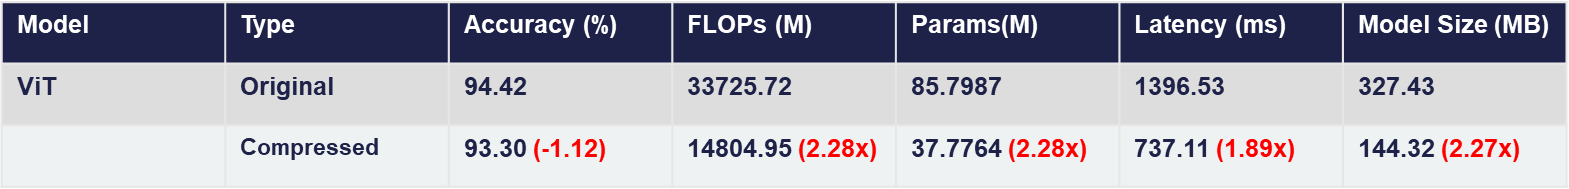
</div>
<div align='center'>
Fig. 1 Compression results of the ViT. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex). We set the model's data type to FP32, and an inference engine to ONNX Runtime to measure the latency.
</div>

<a name="1.-Model-Compression-with-NetsPresso-Model-Compressor"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Setting up your environment


Cloning the ViT code ([link](https://github.com/huggingface/transformers))

In [ ]:
! git clone https://github.com/huggingface/transformers.git

Installing the following packages:

In [ ]:
# You MUST install the compatible torch version with your cuda version. Here, we set PyTorch 1.11.0 with CUDA 11.3 as default. (Support: PyTorch version >= 1.10) 
! pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
! pip install torchsummary
! pip install tensorboardX
! pip install scikit-learn
! pip install onnxruntime
! pip install datasets
! pip install onnx
! pip install thop
! pip install torchinfo

! cd transformers && \
python setup.py develop

❗ Please restart the runtime in order to use the installed packages.

### Preparing the pretrained model

You can get the pretrained ViT (GraphModule format) on CIFAR100 by running the following code block. 
* Or you can train ViT on CIFAR100 in [Appendix 1](#Appendix-1.-Transfer-Learning-on-CIFAR100).

In [ ]:
# Full model
! wget https://netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com/model_zoo/torch/cifar100/pretrained/vit/model.pt
# ViT part of the model
! wget https://netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com/model_zoo/torch/cifar100/pretrained/vit/model_vit.pt

### **ViT compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up for NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the original ViT module `model_vit.pt`. The model format should be `GraphModule` (`torch.fx.GraphModule`).
3. To reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#2.-Fine-tuning-the-Compressed-Model): 
    * `Singular Value Decomposition` &rarr; `Recommendation (VBMF) calibration ratio: 0.2`
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

<div align='center'>
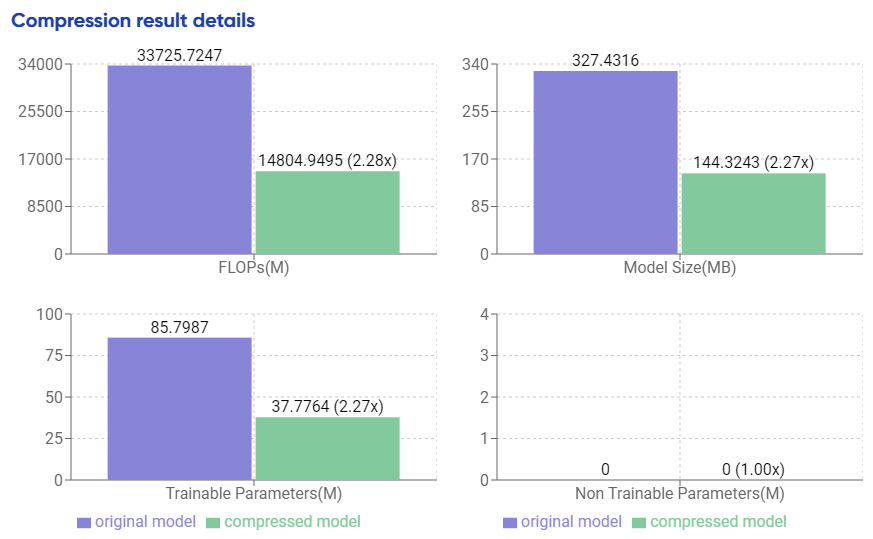
</div>
<div align='center'>
Fig 2. The results of each compression. Compression method: Singular Value Decomposition (calibration ratio: 0.2)
</div>

<a name="2.-Fine-tuning-the-Compressed-Model"></a>
# 2. Fine-tuning the Compressed Model
Singular Value Decomposition (SVD) may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
Here, `Singular Value Decomposition` &rarr; `Fine-tuning`

<a name="Preparing-CIFAR100-dataset"></a>
### Preparing CIFAR100 dataset

In [ ]:
import torch
from datasets import load_dataset, load_metric
from transformers import ViTFeatureExtractor

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize,
                                    ToTensor,
                                    RandAugment)

# load dataset
dataset = load_dataset('cifar100')
image = dataset["train"]["img"]

train_ds = dataset["train"]
test_ds = dataset["test"]


# load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


def transform(example_batch):
    def toRGB(image):
        if image.mode != 'RGB':
            return image.convert("RGB")
        return image
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([toRGB(x) for x in example_batch['img']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['coarse_label']
    return inputs

prepared_ds = dataset.with_transform(transform)

labels = dataset['train'].features['coarse_label'].names

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

_train_transforms = Compose(
        [
            Resize([feature_extractor.size["width"], feature_extractor.size["height"]]),
            RandomHorizontalFlip(),
            RandAugment(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize([feature_extractor.size["width"], feature_extractor.size["height"]]),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    examples['label'] = examples['coarse_label']
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    examples['label'] = examples['coarse_label']
    return examples

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

### Fine-tuning the compressed model

To fine-tune the compressed model on CIFAR100, we need to define the modeling for the dataset.  
You can get the modeling code `modeling_vit_model_compressor.py` by running the following code block. You can see details of the modeling in [Appendix 2](#appendix-2-description-of-the-modifications).

In [ ]:
! cd transformers/src/transformers/models/vit && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/vit/best_practices/classification/torch/vit/modeling_vit_model_compressor.py

In this notebook, we fine-tune ([link](#2.-Fine-tuning-the-Compressed-Model)) and verify ([link](#3.-Compression-Results)) the model for the best practice case of Fig. 1 by default.  
* `model_vit_compressed_model_SVD_02.pt` means the model compressed by `Singular Value Decomposition (calibration ratio: 0.2)`.

In [ ]:
import torch
import numpy as np
from transformers import TrainingArguments, Trainer, ViTFeatureExtractor
from datasets import load_dataset, load_metric

# Load compressed model
model = torch.load('model.pt')
_vit_model = torch.load('model_vit_compressed_model_SVD_02.pt')
model.vit = _vit_model

# training arguments
training_args = TrainingArguments(
  output_dir=f"./results",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=20,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions[0], axis=1), references=p.label_ids)


compressed_trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict before training
predictions = compressed_trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# training
train_results = compressed_trainer.train()
compressed_trainer.save_model()
compressed_trainer.log_metrics("train", train_results.metrics)
compressed_trainer.save_metrics("train", train_results.metrics)
compressed_trainer.save_state()

# predict after training
predictions = compressed_trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# save compressed model
torch.save(compressed_trainer.model, "model_finetuned.pt")
torch.save(compressed_trainer.model.vit, "model_vit_compressed_model_SVD_02_finetuned.pt")

<a name="3.-Compression-Results"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on ViT.

* [Visualizing the optimization process on ViT](#Visualizing-the-optimization-process-on-ViT)
* [Accuracy comparision](#Accuracy-comparision)
* [FLOPs & parameters comparision](#FLOPs-&-Parameters-comparision)
* [Latency comparision](#Latency-comparision)
* [Architecture of the compressed model](#Architecture-of-the-compressed-model)

Loading original & compressed models

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

original_model = torch.load('model.pt',map_location = device)
_original_vit_model = torch.load('/root/workspace/0_Best_practice/vit/model_vit.pt',map_location = device)
original_model.vit = _original_vit_model

compressed_model = torch.load("model_finetuned.pt",map_location = device)
_compressed_model_vit_model = torch.load("model_vit_compressed_model_SVD_02_finetuned.pt",map_location = device)
compressed_model.vit = _compressed_model_vit_model

<a name='Visualizing-the-optimization-process-on-ViT'></a>

<!-- ### Visualization of How NetsPresso Model Compressor Optimizes MobileNetV1 -->
### Visualizing the optimization process on ViT

Fig.3 visualizes part of the original and decomposed ViT.
Here, we applied [Singular Value Decomposition](https://docs.netspresso.ai/docs/mc-filter-decomposition#what-is-filter-decomposition) to optimize the model.
<div align="center">

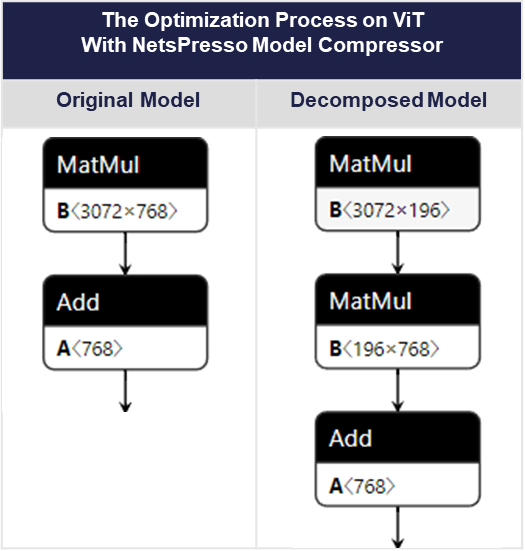
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in ViT with NetsPresso Model Compressor</div>

<a name="Accuracy-comparision"></a>
### Accuracy comparision

Evaluation code for the original model

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

training_args = TrainingArguments(
  output_dir=f"./results",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=0,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions[0], axis=1), references=p.label_ids)


trainer = Trainer(
    model=original_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict 
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

Evaluation code for the compressed model

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

training_args = TrainingArguments(
  output_dir=f"./results",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=0,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions[0], axis=1), references=p.label_ids)


trainer = Trainer(
    model=compressed_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

<a name="FLOPs-&-Parameters-comparision"></a>
### FLOPs & Parameters comparision

In [ ]:
from thop import profile
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = 224

dummy_input = torch.ones((1,3,input_size,input_size)).to(device)

original_macs, _ = profile(original_model.vit.eval(), inputs=(dummy_input, ))
compressed_macs, _ = profile(compressed_model.vit.eval(), inputs=(dummy_input, ))

original_params = summary(original_model.vit.eval(), (1,3,input_size, input_size)).trainable_params
compressed_params = summary(compressed_model.vit.eval(), (1,3,input_size, input_size)).trainable_params

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

<a name="Latency-comparision"></a>
### Latency comparision

In [ ]:
import onnx
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,224,224)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

onnxExport(original_model, 'model.onnx')
onnxExport(compressed_model, 'model_compressed_model_SVD_02.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 224
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('model.onnx',run_times=10)
compressed_latency = inference_time('model_compressed_model_SVD_02.onnx',run_times=10)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

<a name="Architecture-of-the-compressed-model"></a>

### Architecture of the compressed model

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

_compressed_model_vit_model = torch.load('model_vit_compressed_model_SVD_02_finetuned.pt').to(device)

summary(_compressed_model_vit_model.to(device),(3,224,224),device=device)

<a name='Appendix-1.-Transfer-Learning-on-CIFAR100'></a>
# Appendix 1. Transfer Learning on CIFAR100
In this section, we provide the details of how to get pretrained ViT on CIFAR100.

### Transfer Learning

To do transfer learning the ImageNet pretrained ViT on CIFAR100, we need to define the modeling for CIFAR100.  
You can get the modeling code `modeling_vit_model_compressor.py` by running the following code block. You can see descriptions of the modifications from `modeling_vit.py` to `modeling_vit_model_compressor.py` in [Appendix 2](#appendix-2-description-of-the-modifications).

In [ ]:
! cd transformers/src/transformers/models/vit && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/vit/best_practices/classification/torch/vit/modeling_vit_model_compressor.py

Praparing the dataset

- Plase run this [code block](#Preparing-CIFAR100-dataset) to prepare the dataset.

Loading the pretrained ViT on ImageNet

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassificationModelCompressor.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

Transfer Learning the ViT on CIFAR100

In [ ]:
import torch
import time
import numpy as np
from torch import nn
from transformers.models.vit.modeling_vit_model_compressor import ViTForImageClassificationModelCompressor
from transformers import ViTForImageClassification, Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=f"./results",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict before training
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# # training
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# # predict after training
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

torch.save(trainer.model.vit, "model_vit.pt")
torch.save(trainer.model, "model.pt")

<a name="Conversion-into-GraphModule-Format"></a>
### Conversion into GraphModule format

In [ ]:
import torch
from transformers.utils.fx import symbolic_trace

traced = torch.load('model_vit.pt')
graph = torch.fx.Tracer().trace(traced)

traced_model = torch.fx.GraphModule(traced, graph)
torch.save(traced_model,"model_vit.pt")

<a name="#appendix-2-description-of-the-modifications"></a>
# Appendix 2. Description of The Modifications
In this section, we go into detail about the code we've changed for transfer learning.

* `modeling_vit_model_compressor.py`
    * To convert ViT into GraphModule format, we need to check the input value by using `torch._assert`, not `if statement` ([link 1](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dL176)), ([link 2](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR180)), ([link 3](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR185)).
    * As ViT is converted into Graphmodule format, the type of ViT's output changes from `list` to `dict`. Therefore, we change the input parameters for the `vit` module ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR794)),  and the parameters of `ImageClassifierOutput` ([link](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR833)).